# **Transfomer Architecture**


<img src="assets/architecture.png" alt="Screenshot" width="600" />


# Workflow
- input embeddings
- Positonal encoding
- Mutlihead attention(self attention)
- add and norm(layer normalization)
- feed forward network
- Residual network
- Encoder
- Decoder
- Building a Transformer
- testing
- tokenizer
- loading dataset
- validation loop
- training loop
- conclusion

# Importing libs

In [ ]:
# all the important liberires from pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import math

In [ ]:
#HuggingFace linraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
     

In [ ]:
#pathlib
from pathlib import Path
     

#typing
from typing import Any
     

#Library for progress bars in loops
from tqdm import tqdm
     

#importing library of warnings
import warnings

# Input Embedding

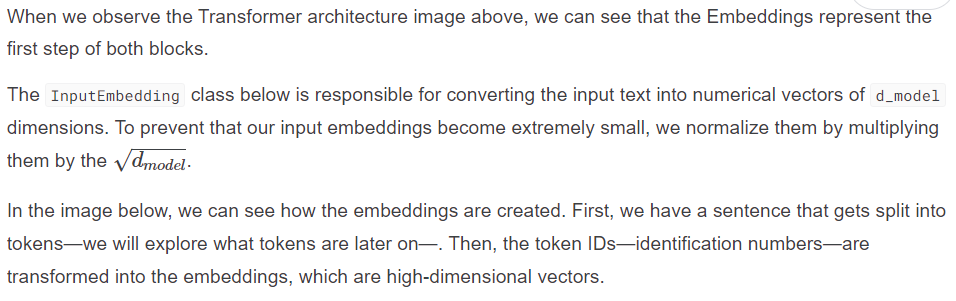

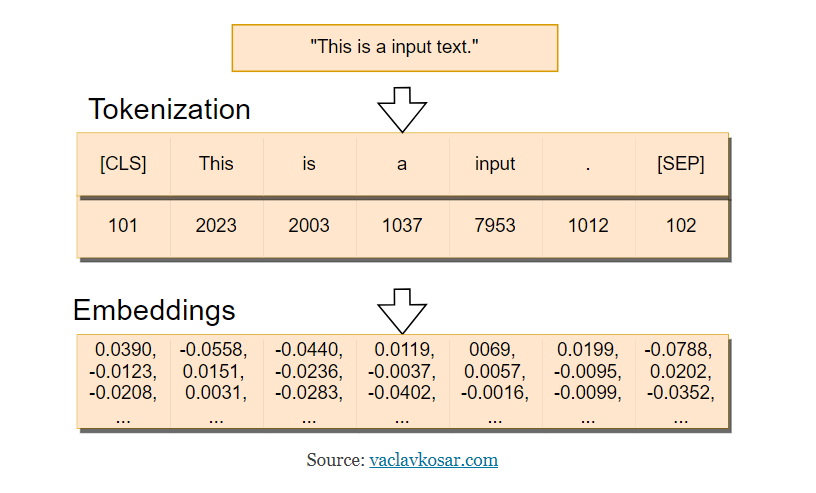

In [3]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model:int = 512, vocab_size:int = 10000):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)


# Positional Encoding

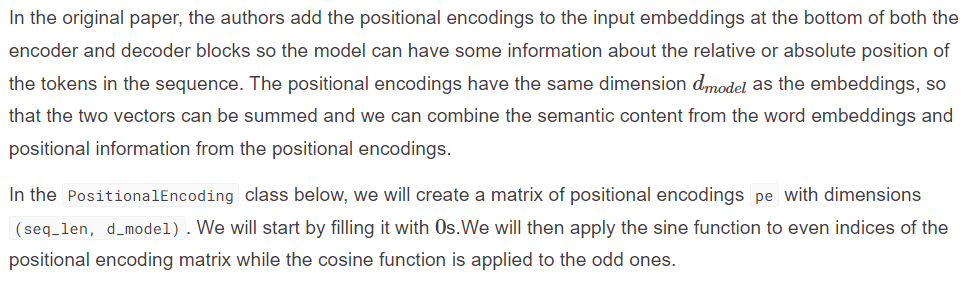

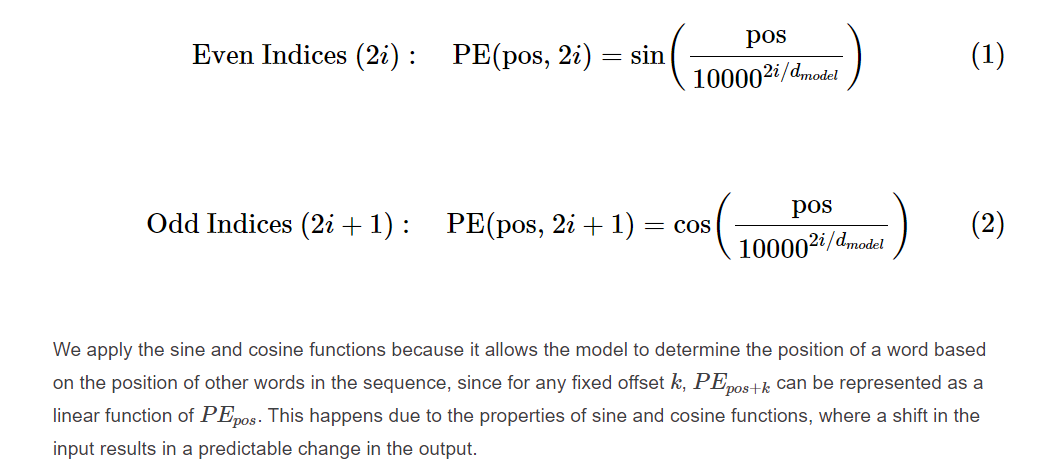

 why self.buffer is here??

If you have parameters in your model, which should be saved and restored in the state_dict, but not trained by the optimizer, you should register them as buffers. Buffers won’t be returned in model.parameters(), so that the optimizer won’t have a change to update them. # register_buffer => Tensor which is not a parameter, but should be part of the modules state. # Used for tensors that need to be on the same device as the module. # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)


In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Dimensionality of the model
        self.seq_len = seq_len # Maximum sequence length
        self.dropout = nn.Dropout(dropout) # Dropout layer to prevent overfitting

        # Creating a positional encoding matrix of shape (seq_len, d_model) filled with zeros
        pe = torch.zeros(seq_len, d_model)

        # Creating a tensor representing positions (0 to seq_len - 1)
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Transforming 'position' into a 2D tensor['seq_len, 1']

        # Creating the division term for the positional encoding formula
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)

        # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
        self.register_buffer('pe', pe)

    def forward(self,x):
        # Addind positional encoding to the input tensor X
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x) # Dropout for regularization

# Layer Normalization

In [ ]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None: # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1)) # One-dimensional tensor that will be used to scale the input data

        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1)) # One-dimensional tenso that will be added to the input data

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(dim = -1, keepdim = True) # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

        # Returning the normalized input
        return self.alpha * (x-mean) / (std + self.eps) + self.bias